In [80]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [81]:
train_df = pd.read_csv("../tsa_train.csv")
test_df = pd.read_csv("../tsa_test.csv")


In [82]:
SEQ_LENGTH = 4 # lookback period
TARGET = 'log_price'

In [83]:
train_df['split'] = 'train'
test_df['split'] = 'test'
full_df = pd.concat([train_df, test_df], ignore_index=True)
full_df = full_df.sort_values(['region', 'period_begin']).reset_index(drop=True)

print(f"Train: {len(train_df)} rows")
print(f"Test:  {len(test_df)} rows")
print(f"Full:  {len(full_df)} rows")

Train: 9090 rows
Test:  2443 rows
Full:  11533 rows


In [84]:
results = {}

In [85]:
def create_sequences_for_zip(zip_df, seq_length, target_col):
    """
    Create sequences for a single zip code.
    Returns X, y, and which split each sequence belongs to.
    """
    prices = zip_df[target_col].values
    splits = zip_df['split'].values
    
    X, y, seq_splits = [], [], []
    
    for i in range(len(prices) - seq_length):
        X.append(prices[i:i + seq_length])
        y.append(prices[i + seq_length])
        # Sequence belongs to whichever split the TARGET is in
        seq_splits.append(splits[i + seq_length])
    
    return np.array(X), np.array(y), seq_splits

## Baseline Models: Naive, Moving Average

In [86]:
def evaluate_baselines(full_df, target_col, seq_length):
    """
    Naive: predict the last known value
    Moving Average: predict average of last N values
    """
    naive_preds, ma_preds, actuals = [], [], []
    
    for zip_code in full_df['region'].unique():
        zip_df = full_df[full_df['region'] == zip_code].sort_values('period_begin')
        prices = zip_df[target_col].values
        splits = zip_df['split'].values
        
        if len(prices) <= seq_length:
            continue
        
        for i in range(seq_length, len(prices)):
            if splits[i] == 'test':
                # Naive: last value
                naive_preds.append(prices[i - 1])
                
                # Moving Average: mean of last seq_length values
                ma_preds.append(np.mean(prices[i - seq_length : i]))
                
                # Actual
                actuals.append(prices[i])
    
    return {
        'naive': np.array(naive_preds),
        'moving_avg': np.array(ma_preds),
        'actual': np.array(actuals)
    }

In [87]:
baseline_results = evaluate_baselines(full_df, TARGET, SEQ_LENGTH)

# Naive model
naive_r2 = r2_score(baseline_results['actual'], baseline_results['naive'])
naive_mae = mean_absolute_error(baseline_results['actual'], baseline_results['naive'])
results['Naive'] = {'R2': naive_r2, 'MAE': naive_mae}
print(f"Naive:          R² = {naive_r2:.4f}, MAE = {naive_mae:.4f}")

# Moving Average
ma_r2 = r2_score(baseline_results['actual'], baseline_results['moving_avg'])
ma_mae = mean_absolute_error(baseline_results['actual'], baseline_results['moving_avg'])
results['Moving Avg'] = {'R2': ma_r2, 'MAE': ma_mae}
print(f"Moving Average: R² = {ma_r2:.4f}, MAE = {ma_mae:.4f}")

Naive:          R² = 0.8330, MAE = 0.0793
Moving Average: R² = 0.7995, MAE = 0.1085


## Statistical Models: ARIMA, Exponential Smoothing

In [88]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def evaluate_statistical_models(full_df, target_col, seq_length):
    """
    ARIMA and Exponential Smoothing predictions.
    These are slower - we'll sample zip codes for efficiency.
    """
    arima_preds, ets_preds, actuals = [], [], []
    
    # Sample zip codes for speed (statistical models are slow)
    zip_codes = full_df['region'].unique()
    sample_zips = np.random.choice(zip_codes, size=min(30, len(zip_codes)), replace=False)
    
    for zip_code in sample_zips:
        zip_df = full_df[full_df['region'] == zip_code].sort_values('period_begin')
        
        # Split into train and test portions
        train_portion = zip_df[zip_df['split'] == 'train'][target_col].values
        test_portion = zip_df[zip_df['split'] == 'test'][target_col].values
        
        if len(train_portion) < 10 or len(test_portion) < 1:
            continue
        
        try:
            # ARIMA - forecast all test periods at once
            arima_model = ARIMA(train_portion, order=(1, 1, 1))
            arima_fit = arima_model.fit()
            arima_forecast = arima_fit.forecast(steps=len(test_portion))
            
            # Exponential Smoothing
            ets_model = ExponentialSmoothing(
                train_portion, 
                trend='add', 
                seasonal=None,
                damped_trend=True
            )
            ets_fit = ets_model.fit()
            ets_forecast = ets_fit.forecast(steps=len(test_portion))
            
            arima_preds.extend(arima_forecast)
            ets_preds.extend(ets_forecast)
            actuals.extend(test_portion)
            
        except Exception as e:
            continue  # Skip problematic series
    
    return {
        'arima': np.array(arima_preds),
        'ets': np.array(ets_preds),
        'actual': np.array(actuals)
    }

print("\nFitting statistical models (this may take a minute)...")
stat_results = evaluate_statistical_models(full_df, TARGET, SEQ_LENGTH)

if len(stat_results['actual']) > 0:
    # ARIMA
    arima_r2 = r2_score(stat_results['actual'], stat_results['arima'])
    arima_mae = mean_absolute_error(stat_results['actual'], stat_results['arima'])
    results['ARIMA'] = {'R2': arima_r2, 'MAE': arima_mae}
    print(f"ARIMA:          R² = {arima_r2:.4f}, MAE = {arima_mae:.4f}")
    
    # Exponential Smoothing
    ets_r2 = r2_score(stat_results['actual'], stat_results['ets'])
    ets_mae = mean_absolute_error(stat_results['actual'], stat_results['ets'])
    results['Exp Smoothing'] = {'R2': ets_r2, 'MAE': ets_mae}
    print(f"Exp Smoothing:  R² = {ets_r2:.4f}, MAE = {ets_mae:.4f}")


Fitting statistical models (this may take a minute)...
ARIMA:          R² = 0.3640, MAE = 0.2479
Exp Smoothing:  R² = 0.4159, MAE = 0.1888


## ML Models with Lag Features: Random Forest, XGBoost

In [89]:
# For ML models, we need to create lag features manually
# Instead of sequences, we create columns: lag_1, lag_2, lag_3, lag_4

def create_lag_features(full_df, target_col, n_lags):
    """
    Create lag features for traditional ML models.
    
    Original: [price_t]
    With lags: [price_t, lag_1, lag_2, lag_3, lag_4]
    
    lag_1 = price at t-1
    lag_2 = price at t-2
    etc.
    """
    lag_dfs = []
    
    for zip_code in full_df['region'].unique():
        zip_df = full_df[full_df['region'] == zip_code].sort_values('period_begin').copy()
        
        # Create lag columns
        for lag in range(1, n_lags + 1):
            zip_df[f'lag_{lag}'] = zip_df[target_col].shift(lag)
        
        lag_dfs.append(zip_df)
    
    result = pd.concat(lag_dfs, ignore_index=True)
    
    # Drop rows with NaN (first n_lags rows per zip)
    result = result.dropna()
    
    return result

# Create lag features
lag_df = create_lag_features(full_df, TARGET, SEQ_LENGTH)

# Define features and target
lag_features = [f'lag_{i}' for i in range(1, SEQ_LENGTH + 1)]

# Split back into train/test
train_lag = lag_df[lag_df['split'] == 'train']
test_lag = lag_df[lag_df['split'] == 'test']

X_train_ml = train_lag[lag_features].values
y_train_ml = train_lag[TARGET].values
X_test_ml = test_lag[lag_features].values
y_test_ml = test_lag[TARGET].values

print(f"\nML dataset shapes:")
print(f"  X_train: {X_train_ml.shape}")
print(f"  X_test:  {X_test_ml.shape}")


ML dataset shapes:
  X_train: (8638, 4)
  X_test:  (2443, 4)


In [90]:
# --- Random Forest ---
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_ml, y_train_ml)
rf_preds = rf_model.predict(X_test_ml)

rf_r2 = r2_score(y_test_ml, rf_preds)
rf_mae = mean_absolute_error(y_test_ml, rf_preds)
results['Random Forest'] = {'R2': rf_r2, 'MAE': rf_mae}
print(f"Random Forest:  R² = {rf_r2:.4f}, MAE = {rf_mae:.4f}")

# --- XGBoost ---
try:
    from xgboost import XGBRegressor
    
    xgb_model = XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
    xgb_model.fit(X_train_ml, y_train_ml)
    xgb_preds = xgb_model.predict(X_test_ml)
    
    xgb_r2 = r2_score(y_test_ml, xgb_preds)
    xgb_mae = mean_absolute_error(y_test_ml, xgb_preds)
    results['XGBoost'] = {'R2': xgb_r2, 'MAE': xgb_mae}
    print(f"XGBoost:        R² = {xgb_r2:.4f}, MAE = {xgb_mae:.4f}")
except ImportError:
    print("XGBoost not installed, skipping...")

Random Forest:  R² = 0.8176, MAE = 0.0920
XGBoost:        R² = 0.7979, MAE = 0.0941


## Deep Learning: LSTM and GRU

In [91]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

def create_sequences_with_split(full_df, target_col, seq_length):
    """Create sequences and track train/test split."""
    X_train, y_train = [], []
    X_test, y_test = [], []
    scalers = {}
    
    for zip_code in full_df['region'].unique():
        zip_df = full_df[full_df['region'] == zip_code].sort_values('period_begin')
        
        if len(zip_df) <= seq_length:
            continue
        
        prices = zip_df[target_col].values
        splits = zip_df['split'].values
        
        # Fit scaler on training portion only
        train_prices = prices[splits == 'train']
        if len(train_prices) == 0:
            continue
            
        scaler = MinMaxScaler()
        scaler.fit(train_prices.reshape(-1, 1))
        prices_scaled = scaler.transform(prices.reshape(-1, 1)).flatten()
        scalers[zip_code] = scaler
        
        # Create sequences
        for i in range(len(prices_scaled) - seq_length):
            seq_X = prices_scaled[i : i + seq_length]
            seq_y = prices_scaled[i + seq_length]
            
            if splits[i + seq_length] == 'train':
                X_train.append(seq_X)
                y_train.append(seq_y)
            else:
                X_test.append(seq_X)
                y_test.append(seq_y)
    
    return (np.array(X_train), np.array(y_train),
            np.array(X_test), np.array(y_test), scalers)

# Create sequences
X_train_dl, y_train_dl, X_test_dl, y_test_dl, scalers = create_sequences_with_split(
    full_df, TARGET, SEQ_LENGTH
)

# Reshape for LSTM/GRU: (samples, timesteps, features)
X_train_dl = X_train_dl.reshape((X_train_dl.shape[0], SEQ_LENGTH, 1))
X_test_dl = X_test_dl.reshape((X_test_dl.shape[0], SEQ_LENGTH, 1))

print(f"\nDeep learning dataset:")
print(f"  X_train: {X_train_dl.shape}")
print(f"  X_test:  {X_test_dl.shape}")


Deep learning dataset:
  X_train: (8638, 4, 1)
  X_test:  (2443, 4, 1)


In [92]:
# --- LSTM ---
print("\nTraining LSTM...")

lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(SEQ_LENGTH, 1)),
    Dropout(0.2),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

lstm_history = lstm_model.fit(
    X_train_dl, y_train_dl,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=0
)

lstm_preds = lstm_model.predict(X_test_dl, verbose=0).flatten()
lstm_r2 = r2_score(y_test_dl, lstm_preds)
lstm_mae = mean_absolute_error(y_test_dl, lstm_preds)
results['LSTM'] = {'R2': lstm_r2, 'MAE': lstm_mae}
print(f"LSTM:           R² = {lstm_r2:.4f}, MAE = {lstm_mae:.4f}")


Training LSTM...


LSTM:           R² = 0.7710, MAE = 0.0919


In [93]:
# --- GRU ---
print("\nTraining GRU...")

gru_model = Sequential([
    GRU(50, activation='relu', input_shape=(SEQ_LENGTH, 1)),
    Dropout(0.2),
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mse')

gru_history = gru_model.fit(
    X_train_dl, y_train_dl,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=0
)

gru_preds = gru_model.predict(X_test_dl, verbose=0).flatten()
gru_r2 = r2_score(y_test_dl, gru_preds)
gru_mae = mean_absolute_error(y_test_dl, gru_preds)
results['GRU'] = {'R2': gru_r2, 'MAE': gru_mae}
print(f"GRU:            R² = {gru_r2:.4f}, MAE = {gru_mae:.4f}")


Training GRU...
GRU:            R² = 0.4106, MAE = 0.1607


## Results

MODEL COMPARISON - Time Series Forecasting
Test Period: 2020-2021 (COVID Era)


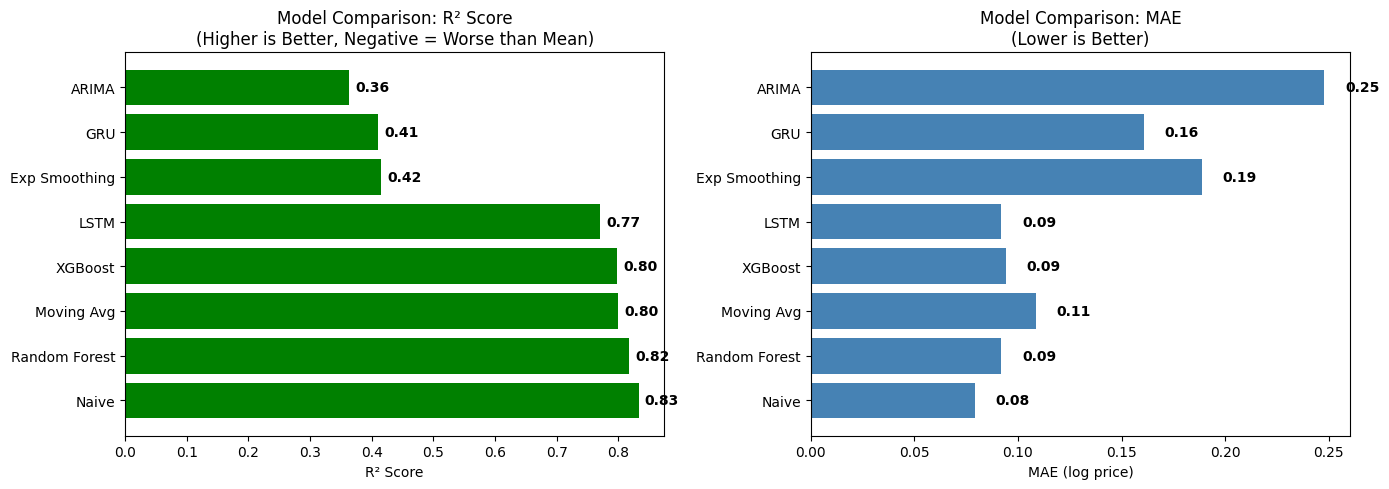


🏆 Best Model: Naive (R² = 0.8330)


In [94]:
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('R2', ascending=False)

print("MODEL COMPARISON - Time Series Forecasting")
print("Test Period: 2020-2021 (COVID Era)")
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² comparison
colors = ['green' if x > 0 else 'red' for x in results_df['R2']]
axes[0].barh(results_df.index, results_df['R2'], color=colors)
axes[0].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
for i, v in enumerate(results_df['R2']):
    axes[0].text(v + (0.01 if v >= 0 else -0.01), i, f"{v:.2f}", va='center', 
                 ha='left' if v >= 0 else 'right', color='black', fontweight='bold')
axes[0].set_xlabel('R² Score')
axes[0].set_title('Model Comparison: R² Score\n(Higher is Better, Negative = Worse than Mean)')

# MAE comparison
axes[1].barh(results_df.index, results_df['MAE'], color='steelblue')
for i, v in enumerate(results_df['MAE']):
    axes[1].text(v + 0.01, i, f"{v:.2f}", va='center', ha='left', color='black', fontweight='bold')
axes[1].set_xlabel('MAE (log price)')
axes[1].set_title('Model Comparison: MAE\n(Lower is Better)')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150)
plt.show()

# Best model
best_model = results_df['R2'].idxmax()
print(f"\n🏆 Best Model: {best_model} (R² = {results_df.loc[best_model, 'R2']:.4f})")

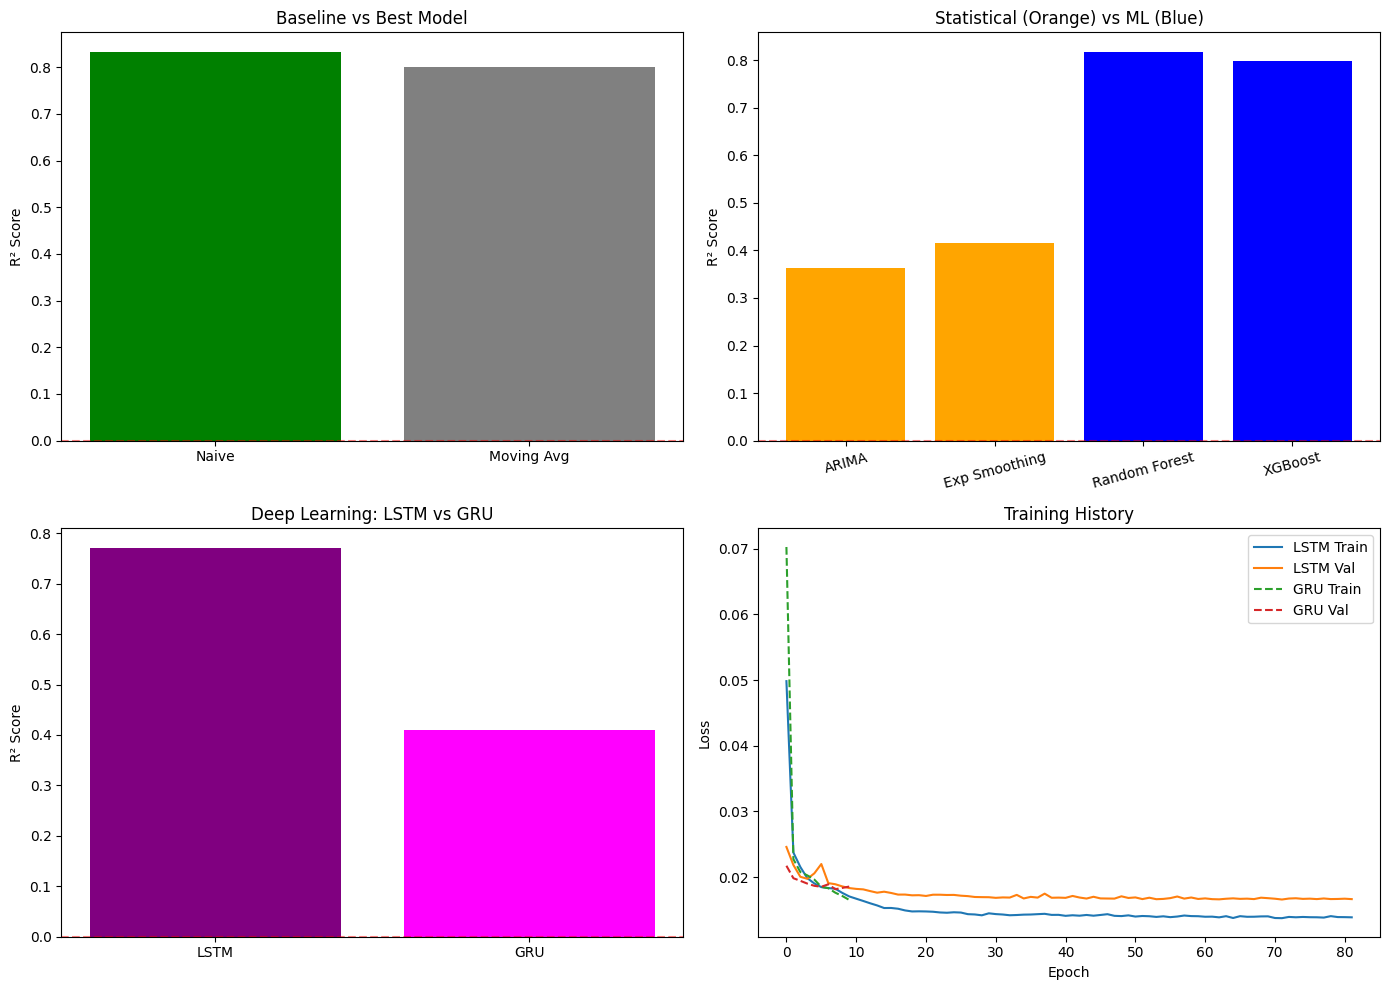

In [95]:
# ============================================================
# ANALYSIS BY CATEGORY
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Baseline vs Best
axes[0,0].bar(['Naive', 'Moving Avg', best_model], 
              [results['Naive']['R2'], results['Moving Avg']['R2'], results[best_model]['R2']],
              color=['gray', 'gray', 'green'])
axes[0,0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[0,0].set_ylabel('R² Score')
axes[0,0].set_title('Baseline vs Best Model')

# 2. Statistical vs ML
stat_models = ['ARIMA', 'Exp Smoothing'] if 'ARIMA' in results else []
ml_models = ['Random Forest', 'XGBoost'] if 'XGBoost' in results else ['Random Forest']
all_models = stat_models + ml_models

if all_models:
    r2_vals = [results[m]['R2'] for m in all_models if m in results]
    model_names = [m for m in all_models if m in results]
    colors = ['orange' if m in stat_models else 'blue' for m in model_names]
    axes[0,1].bar(model_names, r2_vals, color=colors)
    axes[0,1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    axes[0,1].set_ylabel('R² Score')
    axes[0,1].set_title('Statistical (Orange) vs ML (Blue)')
    axes[0,1].tick_params(axis='x', rotation=15)

# 3. Deep Learning comparison
dl_models = ['LSTM', 'GRU']
dl_r2 = [results[m]['R2'] for m in dl_models]
axes[1,0].bar(dl_models, dl_r2, color=['purple', 'magenta'])
axes[1,0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1,0].set_ylabel('R² Score')
axes[1,0].set_title('Deep Learning: LSTM vs GRU')

# 4. Training curves
axes[1,1].plot(lstm_history.history['loss'], label='LSTM Train')
axes[1,1].plot(lstm_history.history['val_loss'], label='LSTM Val')
axes[1,1].plot(gru_history.history['loss'], label='GRU Train', linestyle='--')
axes[1,1].plot(gru_history.history['val_loss'], label='GRU Val', linestyle='--')
axes[1,1].set_xlabel('Epoch')
axes[1,1].set_ylabel('Loss')
axes[1,1].set_title('Training History')
axes[1,1].legend()

plt.tight_layout()
plt.savefig('model_analysis.png', dpi=150)
plt.show()